# Load All Packages

In [18]:
# load packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import math, itertools, os, shapely
from shapely.geometry import Polygon, Point

from scipy import ndimage as ndi
from skimage import feature, io
from skimage.transform import rotate
from skimage.feature import match_template, peak_local_max
import cv2

from ortools.linear_solver import pywraplp as OR

# Adjust All Variables (As Needed)

In [19]:
Screen_Height=1080
Screen_Width=1920
floor='WRN151.jpg'
floor_alt='WRN-151-alt.jpg'
solution_name="WRN-151-sol-15footscale"
feetyardStick=15.0 #how many feet long the yardstick is
Chair_Scale=10
finding_threshold=0.6
floorU = cv2.imread(floor, cv2.IMREAD_UNCHANGED)
floor_str = floor
floor2U = cv2.imread(floor_alt, cv2.IMREAD_UNCHANGED)
floor2_str = floor_alt
t_box = 'bottom'    # t box starts from: 'top', 'bottom', 'left', or 'right'

# SETUP:

In [20]:
if floorU.shape[0] > Screen_Height:
    height=floorU.shape[0]
    Window_Height=Screen_Height
else:
    height=Screen_Height
    Window_Height=floorU.shape[0]-1
if floorU.shape[1]>Screen_Width:
    width=floorU.shape[1]
    Window_Width=Screen_Width
else:
    width=Screen_Width
    Window_Width=floorU.shape[1]-1
NonWritableImage=cv2.imread(floor)
WritableImage=cv2.imread(floor)

In [21]:
# get lh, .., uw from full set of 4 coordinates
def getCoords(rect):
    """
    Takes an np.array with coords of rectangle.
    Returns max / min height / width
    """
    lw = min(rect[:,0])
    uw = max(rect[:,0])
    lh = min(rect[:,1])
    uh = max(rect[:,1])

    return(lw, uw, lh, uh)

In [22]:
# a model for counting seats (function by Jody Zhu)

# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def miset(nodes,edges,solver):
    NODES = []
    NODES.extend(nodes)    # these four lines are not necessary
    EDGES = []             # made a copy in case the lists will be modified
    EDGES.extend(edges)
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in NODES:
        x[i] = m.IntVar(0, 1, ('%s' % (i))) 
        
    # objective function
    m.Maximize(sum(x[i] for i in NODES))
        
    # subject to: no more than 1 node from an edge
    for edge in EDGES:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    sol = {}
    for i in NODES:
        sol.update( {x[i].name() : x[i].solution_value()} )

    print('Total seats:', m.Objective().Value())
    
    return(sol)

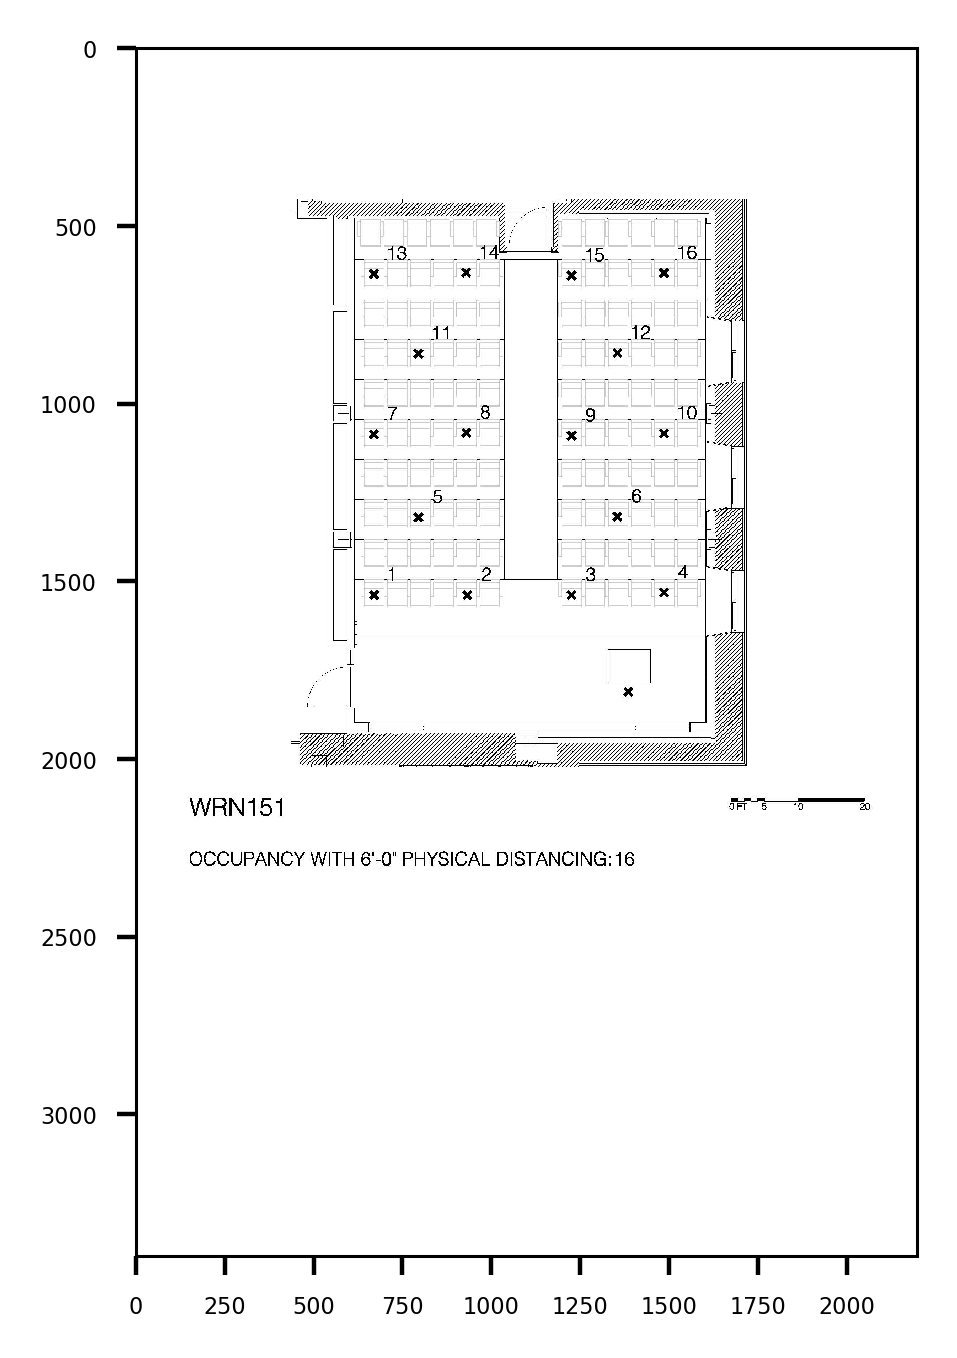

In [23]:
# plot raw image
img = cv2.imread(floor)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=400)

# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    
ax.imshow(img)

Highlight all the chair types (including identical chairs at different rotations), when highlighting, give a little bit of extra room so that you can fully define the polygons more easily later on.


In [24]:
# declare chair locations
template=[(0,0)]
chairs = []
ref = []
cv2.namedWindow("Chair Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Chair Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Chair Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Chair Selection", scrollWidth, (width-Screen_Width),TrackbarChange)

def chair_selection(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
        count += 1
    elif event == cv2.EVENT_LBUTTONUP:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
        rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
        cv2.imshow("Chair Selection", rect)
    elif event == cv2.EVENT_RBUTTONDOWN:   # right-click to delete last selection
        del ref[-1]
        del ref[-1]

cv2.setMouseCallback("Chair Selection", chair_selection)
clone=WritableImage.copy()
while True:
    cv2.resizeWindow("Chair Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Chair Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Chair Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Chair Selection", Image)
    
    key = cv2.waitKey(1) & 0xFF

    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        ref=[]
        WritableImage = clone.copy()

    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break

for r in range(len(ref)//2):
    x1 = ref[2*r][0]
    y1 = ref[2*r][1]
    x2 = ref[2*r+1][0]
    y2 = ref[2*r+1][1]
    ch = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    chairs.append(ch)

print(chairs)
WritableImage=clone.copy()

[array([[634, 594],
       [704, 594],
       [704, 674],
       [634, 674]]), array([[635, 707],
       [705, 707],
       [705, 788],
       [635, 788]])]


Highlight the Scale by dragging from the bottom left corner to the top right corner (NOTE: THIS WILL NEED TO BE MODIFIED FOR IMAGES THAT HAVE A VERTICAL SCALE)


In [25]:
ref=[]
avger=[]
coords=(0,0)
clone=WritableImage.copy()
cv2.namedWindow("Scale Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Scale Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Scale Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Scale Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        count+=1
    elif event == cv2.EVENT_LBUTTONUP:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
        cv2.imshow("Scale Selection", rect)
cv2.setMouseCallback("Scale Selection",set_coords)
clone = img.copy()
while True:
    cv2.resizeWindow("Scale Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Scale Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Scale Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Scale Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        WritableImage = clone.copy()
        ref=[]
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break
for r in range(len(ref)//2):
    x1 = ref[2*r][0]
    y1 = ref[2*r][1]
    x2 = ref[2*r+1][0]
    y2 = ref[2*r+1][1]
    if(x1>x2):
        xTemp=x1
        x1=x2
        x2=xTemp
    if(y1>y2):
        yTemp=y1
        y1=y2
        y2=yTemp
    ys = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    avger.append(ys)
x1avg=0
x2avg=0
y1avg=0
y2avg=0
for ys in avger:
    x1avg+=ys[0][0]
    x2avg+=ys[1][0]
    y1avg+=ys[0][1]
    y2avg+=ys[1][1]
x1avg=x1avg/len(avger)
x2avg=x2avg/len(avger)
y1avg=y1avg/len(avger)
y2avg=y2avg/len(avger)
yardStick=np.array([(x1avg,y1avg),(x2avg,y1avg),(x2avg,y2avg),(x1avg,y2avg)])
print(yardStick)
Stick=Polygon(yardStick)
feet6=6.0/feetyardStick*(x2avg-x1avg)
feet10=5/3*feet6
print(str(feetyardStick)+' feet = %d pixels.' % (x2avg-x1avg))
print(' 6 feet = %.1f pixels' % feet6)

[[1671. 2110.]
 [2050. 2110.]
 [2050. 2110.]
 [1671. 2110.]]
15.0 feet = 379 pixels.
 6 feet = 151.6 pixels


In [26]:
#Check Scale
cv2.namedWindow("ScaleCheck",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("ScaleCheck",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
CheckPoints=[]
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "ScaleCheck", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "ScaleCheck", scrollWidth, (width-Screen_Width),TrackbarChange)
ref = []
def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "ScaleCheck"), y+cv2.getTrackbarPos("Hscroll", "ScaleCheck")))
        print((x,y))
        door=cv2.circle(WritableImage,ref[-1],int(feet6/2),(0,255,0),1,1)
        cv2.imshow("ScaleCheck", door)
cv2.setMouseCallback("ScaleCheck", get_coords)
while True:
    cv2.resizeWindow("ScaleCheck", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "ScaleCheck")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "ScaleCheck")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("ScaleCheck", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
CheckPoints=ref


(1680, 358)
(603, 575)


Drag mouse click accross the bottom of the teach occupied zone. The code will make the teacher zone occupy the 10 feet above that.


In [27]:
#Define the teacher area
cv2.namedWindow("Teacher Box Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Teacher Box Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Teacher Box Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Teacher Box Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
ref = []
def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        if ref != []:
            del ref[-1]
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Teacher Box Selection"), y+cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")))
        print((x,y))
    elif event == cv2.EVENT_LBUTTONUP:
        if t_box == 'top' or t_box == 'bottom':
            if t_box == 'top':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]-feet6),int(temp[1])))
                ref.append((int(temp[0]+feet6),int(temp[1]+feet10)))
            if t_box == 'bottom':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]-feet6),int(temp[1]-feet10)))
                ref.append((int(temp[0]+feet6),int(temp[1])))
        if t_box == 'left' or t_box == 'right':
            if t_box == 'left':
                temp_x = math.floor(ref[0][0] + feet10)
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]),int(temp[1]+feet6)))
                ref.append((int(temp[0]+feet10),int(temp[1]-feet6)))
            if t_box == 'right':
                temp=ref[0]
                del ref[-1]
                ref.append((int(temp[0]),int(temp[1]+feet6)))
                ref.append((int(temp[0]-feet10),int(temp[1]-feet6)))
        print(ref)
        rect = cv2.rectangle(WritableImage, ref[0], ref[1], (0, 255, 0), 1)
        cv2.imshow("Teacher Box Selection", rect)
cv2.setMouseCallback("Teacher Box Selection", get_coords)
while True:
    cv2.resizeWindow("Teacher Box Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Teacher Box Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Teacher Box Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
nogozone = np.array([ref[0], (ref[0][0], ref[1][1]), ref[1], (ref[1][0], ref[0][1])])
zone = Polygon(nogozone)

(1386, 535)
[(1234, 1644), (1537, 1897)]


Run to match all chairs in the diagram

In [28]:
# initialize empty array
x = np.array([])
y = np.array([])
ctype = np.array([])

# extract all types of chairs
for i in range(len(chairs)):
    cds = getCoords(chairs[i])
    chair = NonWritableImage[cds[2]:cds[3], cds[0]:cds[1]] # get chair template
    
    # run matching function (may take a minute or two)
    result = match_template(NonWritableImage, chair, pad_input=True)
    points = peak_local_max(result, min_distance=1, threshold_rel=finding_threshold) # find our peaks (our location points)
    
    print('Matching chair %d: found %d points.' % (i, len(points)))
    
    # add points to list
    x = np.append(x, points[:,1])
    y = np.append(y, points[:,0])
    ctype = np.append(ctype, np.repeat(i, len(points)))
    
    # add points to cv2
    for i in range(len(points)):
        center_coordinates = (points[i,1], points[i,0])
        cv2.circle(WritableImage, center_coordinates, 2, (0,0,204), 2)
    
print('Matching done. Found %d points in total.' % len(ctype))

Matching chair 0: found 17 points.
Matching chair 1: found 90 points.
Matching done. Found 107 points in total.


In [29]:
# store output in dataframe
df = pd.DataFrame(list(zip(x, y, ctype)),  columns = ['x', 'y', 'type'])

Verify the matching worked

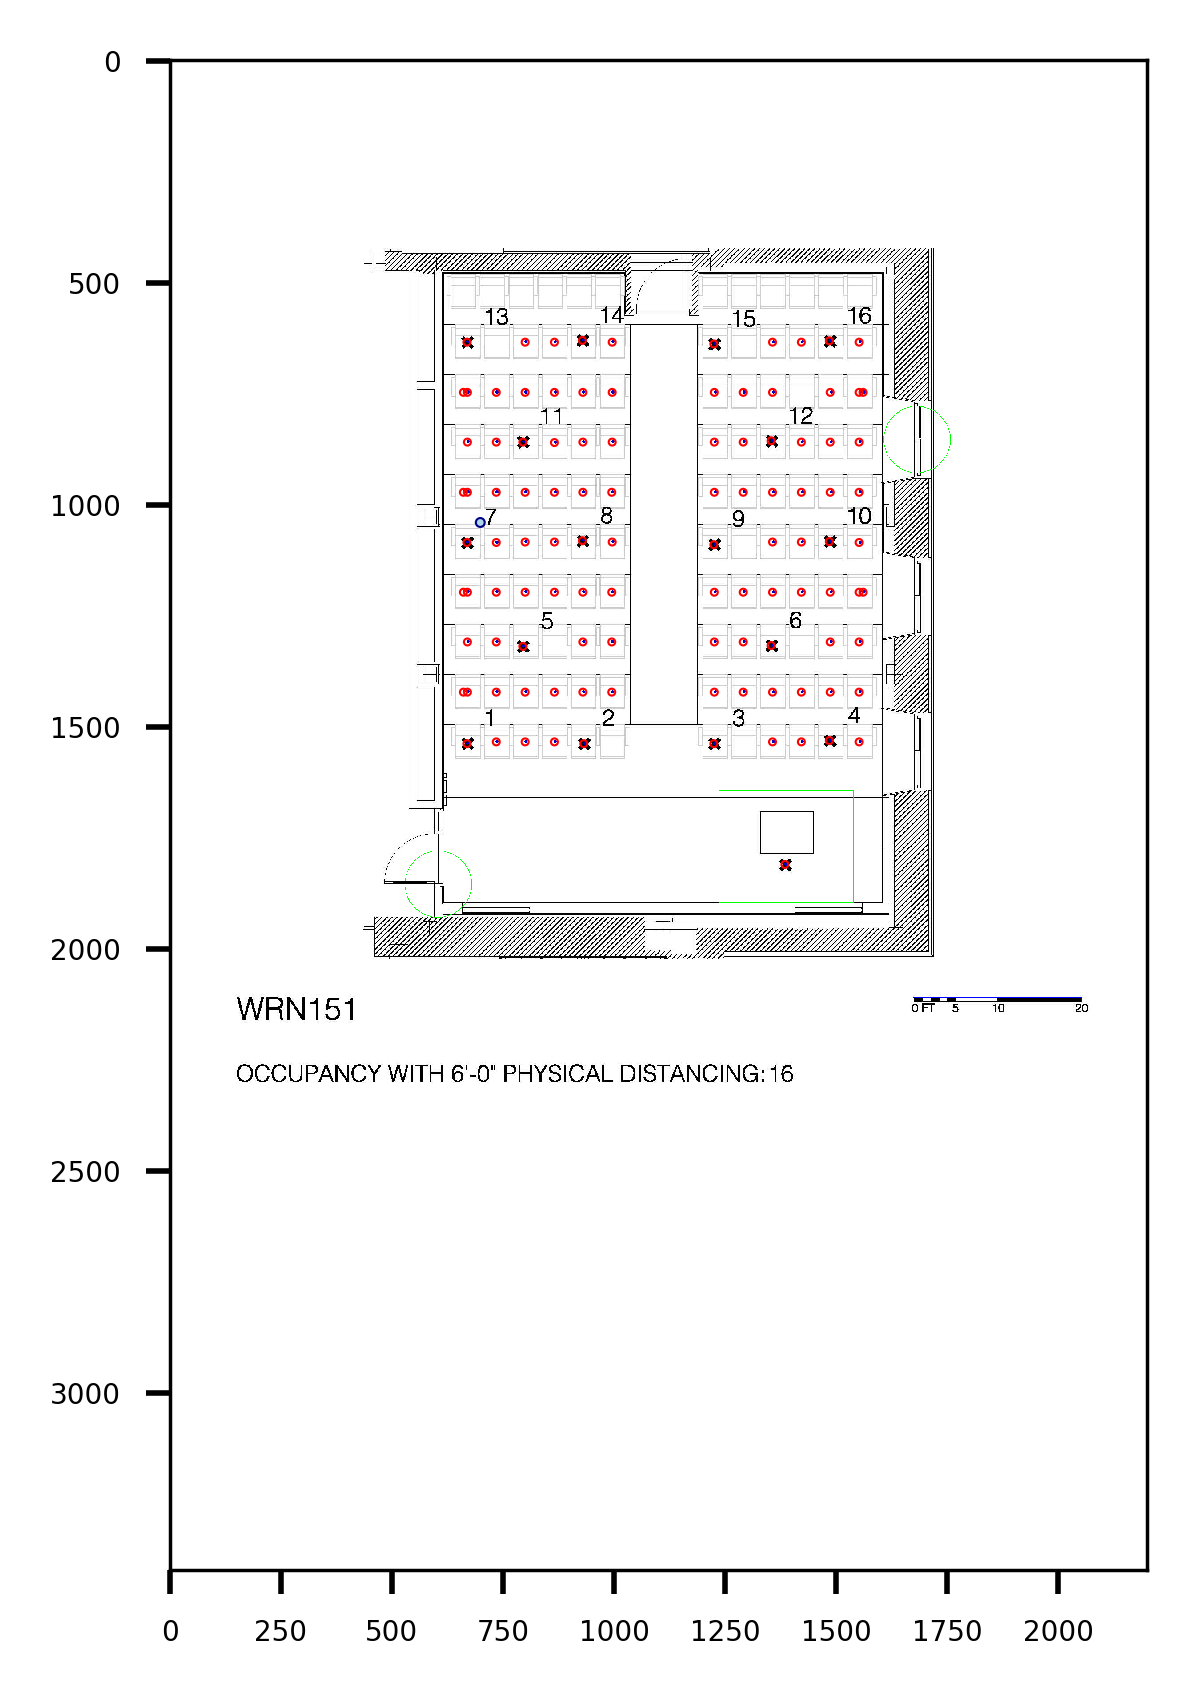

In [30]:
# plot all points to verify the matching worked
# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=500)
#plt.axis('off')

# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    
# draw a circle to locate extra seats
draw_circle = plt.Circle((699, 1040), 10, fill=True, fc='lightblue',
                         ec='darkblue', ls='-', lw=0.3)
ax.add_artist(draw_circle)
    
# plot points
plt.scatter(df['x'], df['y'], s=1, facecolors='none', edgecolors='red',
            alpha=1, marker='o', linewidth=0.3, linestyle='-', zorder=4)   

ax.imshow(WritableImage)

Add missing chairs. Add all of the first highlighted type then press e. Do the same for the second highlighted type in the new window. Keep repeating


In [31]:
for chair in range(len(chairs)):
    cds = getCoords(chairs[chair])
    template = NonWritableImage[cds[2]:cds[3], cds[0]:cds[1]]#template is the subsection of img that contains the chair
    TempHeight=len(template)#gets the height of the subsection
    TempWidth=len(template[0])#gets the width of the subsection
    cv2.namedWindow("chair"+str(chair))#makes a window for the chair
    cv2.resizeWindow("chair"+str(chair), (Chair_Scale*TempWidth,Chair_Scale*TempHeight))#resizes the window to be 4 times the original size
    template=cv2.resize(template,(Chair_Scale*TempWidth,Chair_Scale*TempHeight))#resizes the image to be 4 times the original size
    cv2.imshow('chair'+str(chair),template)
    cv2.namedWindow('add chair '+str(chair),cv2.WINDOW_AUTOSIZE)
    cv2.resizeWindow('add chair '+str(chair),Window_Width, Window_Height)
    scrollHeight=0
    scrollWidth=0
    def TrackbarChange(integer):
        return
    cv2.createTrackbar("Hscroll", 'add chair '+str(chair), scrollHeight, (height-Screen_Height),TrackbarChange)
    cv2.createTrackbar("Wscroll", 'add chair '+str(chair), scrollWidth, (width-Screen_Width),TrackbarChange)
    pt = []
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            pt.append([y+cv2.getTrackbarPos("Hscroll", 'add chair '+str(chair)),x+cv2.getTrackbarPos("Wscroll", 'add chair '+str(chair))])
            center_coordinates = (x+cv2.getTrackbarPos("Wscroll", 'add chair '+str(chair)), y+cv2.getTrackbarPos("Hscroll", 'add chair '+str(chair)))
            color = (0,0,204)
            cv2.circle(WritableImage, center_coordinates, 2, color, 2)
            cv2.imshow('add chair '+str(chair),WritableImage)
            cv2.imshow('chair'+str(chair),template)

    cv2.setMouseCallback('add chair '+str(chair), click_event)
    cv2.imshow('chair'+str(chair),template)
    while True:
        cv2.resizeWindow('add chair '+str(chair), Window_Width, Window_Height)
        scrollHeight=cv2.getTrackbarPos("Hscroll", 'add chair '+str(chair))
        scrollWidth=cv2.getTrackbarPos("Wscroll", 'add chair '+str(chair))
        ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
        cds = getCoords(ShownImage)
        Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
        cv2.imshow('add chair '+str(chair), Image)
        key = cv2.waitKey(1) & 0xFF
        # if the 'e' key is pressed, break from the loop
        if key == ord("e"):
            cv2.destroyAllWindows()
            break
    a = np.array(pt)
    pt = a.reshape(len(a), 2)
    # append
    startloc = len(df)
    for n in range(len(pt)):
        df.loc[startloc+n] = [pt[n,1], pt[n,0], chair]

Delete all incorrect chairs.

In [32]:

cv2.namedWindow("Delete Chairs",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Delete Chairs",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Delete Chairs", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Delete Chairs", scrollWidth, (width-Screen_Width),TrackbarChange)

def point_deletion(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        dref.append((x+cv2.getTrackbarPos("Wscroll", "Delete Chairs"), y+cv2.getTrackbarPos("Hscroll", "Delete Chairs")))
        count += 1
    elif event == cv2.EVENT_LBUTTONUP:
        dref.append((x+cv2.getTrackbarPos("Wscroll","Delete Chairs"), y+cv2.getTrackbarPos("Hscroll","Delete Chairs")))
        cv2.rectangle(WritableImage, dref[2*count-2], dref[2*count-1], (0, 0, 255), 1)
        #cv2.imshow("Delete Chairs", WritableImage)
    elif event == cv2.EVENT_RBUTTONDOWN:   # right-click to delete last selection
        del dref[-1]
        del dref[-1]
dref = []    # ref for deleted points
cv2.setMouseCallback("Delete Chairs", point_deletion)
while True:
    cv2.resizeWindow("Delete Chairs", Window_Width, Window_Height)
    img = cv2.imread(floor)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Delete Chairs")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Delete Chairs")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Delete Chairs", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
points=[]

for r in range(len(dref)//2):
    x1 = dref[2*r][0]
    y1 = dref[2*r][1]
    x2 = dref[2*r+1][0]
    y2 = dref[2*r+1][1]
    if(x1>x2):
        x_temp=x1
        x1=x2
        x2=x_temp
    if(y1>y2):
        y_temp=y1
        y1=y2
        y2=y_temp
    for m in range(x1,x2):
        for n in range(y1,y2):
            rows = df.loc[(df['x'] == m) & (df['y'] == n)].index.tolist()
            for item in rows:
                points.append(item)

points.sort(reverse=True)
print(points)
for loc in range(len(points)):
    df = df.drop(df.index[points[loc]])

[100, 88, 77, 57, 44, 35, 0]


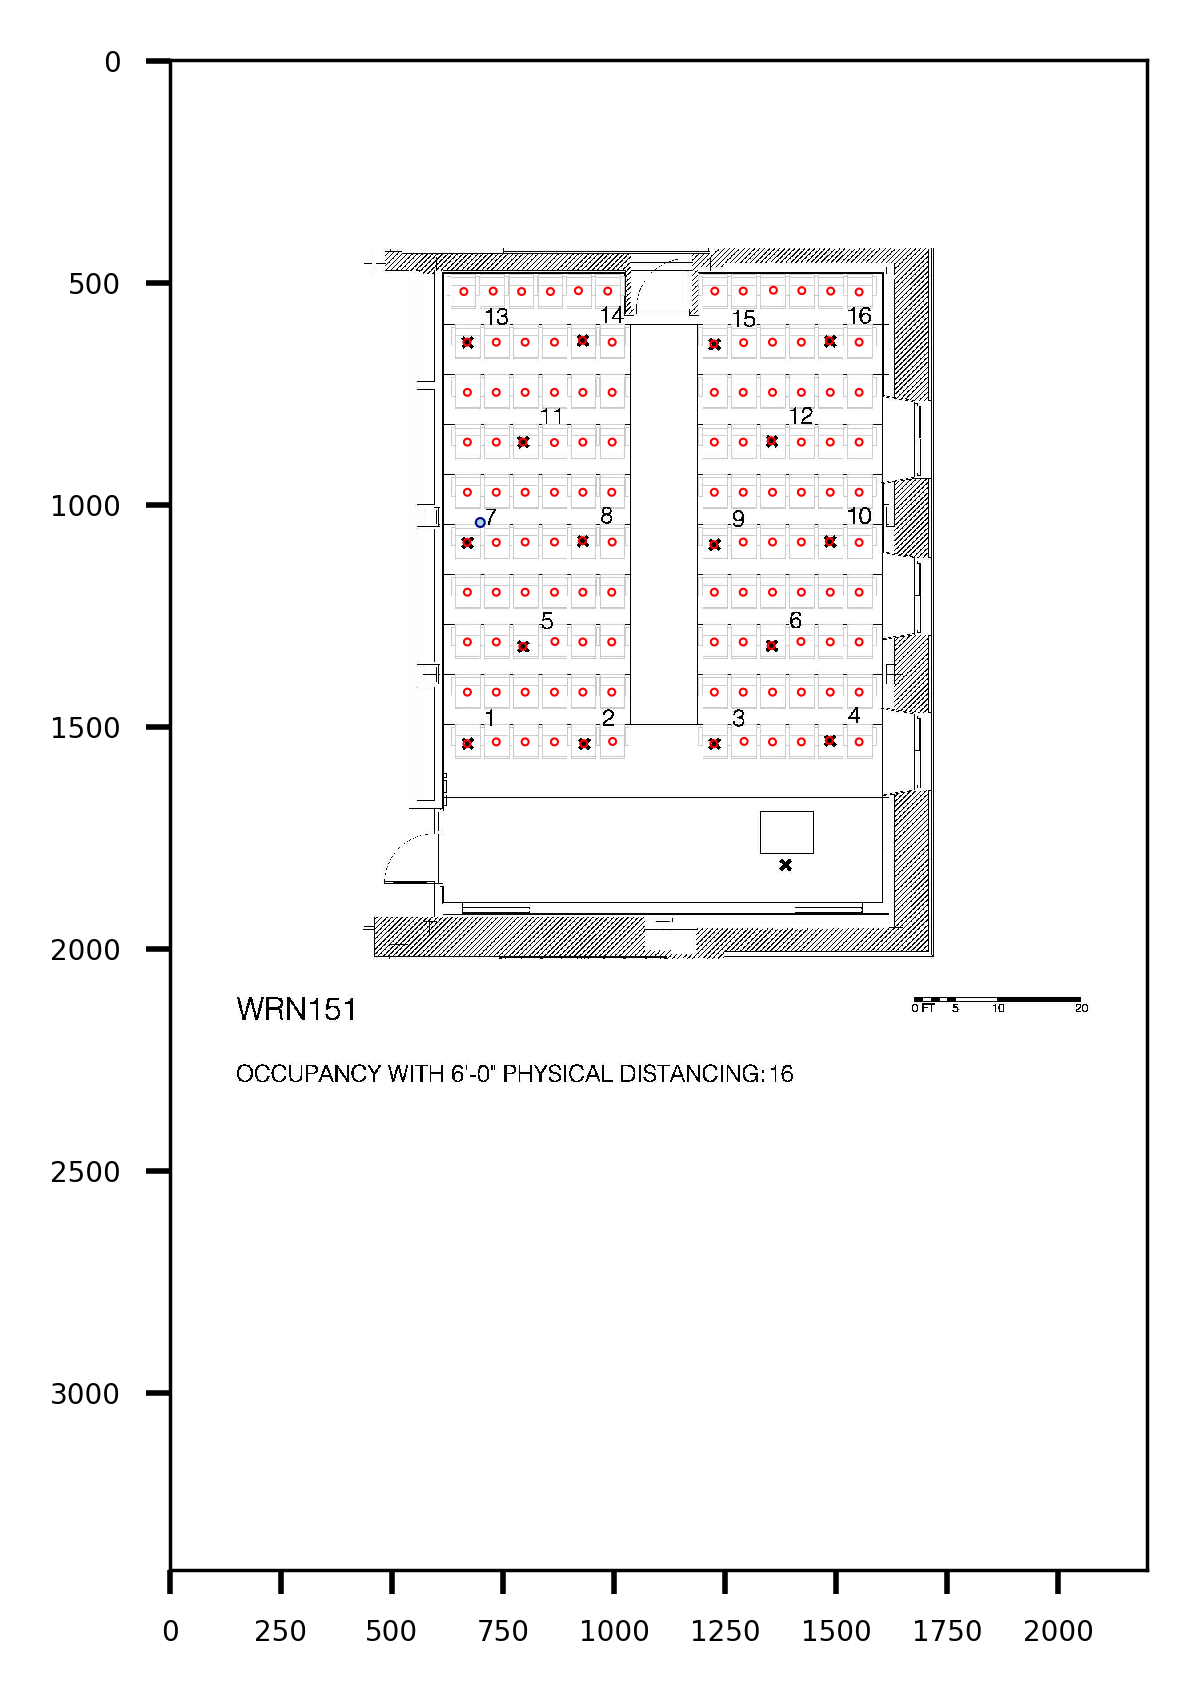

In [33]:
# plot all points to verify all chairs are included now
img = cv2.imread(floor)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=500)
#plt.axis('off')

# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    
# draw a circle to locate extra seats
draw_circle = plt.Circle((699, 1040), 10, fill=True, fc='lightblue',
                         ec='darkblue', ls='-', lw=0.3)
ax.add_artist(draw_circle)
    
# plot points
plt.scatter(df['x'], df['y'], s=1, facecolors='none', edgecolors='red',
            alpha=1, marker='o', linewidth=0.3, linestyle='-', zorder=4)   

ax.imshow(img)

In [34]:
df.reset_index(inplace=True)

click around the edges of each chair to define the polygon shape (shown by red lines between points) The final line will be added to the polygon automatically. Press e to continue to the next chair


In [35]:
#Create Polygons for each selected chair type
polygons={}
xoffsets={}
yoffsets={}
# put polygons into dataframe
df['poly'] = df['type'].map(polygons)
Polygons=[]#The list of polygons in the same order as chairtype
for i in range(len(chairs)):#for each chair
    cds = getCoords(chairs[i])
    template = NonWritableImage[cds[2]:cds[3], cds[0]:cds[1]]#template is the subsection of img that contains the chair
    height=len(template)#gets the height of the subsection
    width=len(template[0])#gets the width of the subsection
    xoffsets[i]=-width/2
    yoffsets[i]=-height/2
    ref=[]#creates array ref[] that is used to store all points that will be added to the polygon
    cv2.namedWindow("chair"+str(i))#makes a window for the chair
    cv2.resizeWindow("chair"+str(i), (Chair_Scale*width,Chair_Scale*height))#resizes the window to be 4 times the original size
    template=cv2.resize(template,(Chair_Scale*width,Chair_Scale*height))#resizes the image to be 4 times the original size
    def polygon_creation(event, x, y, flags, param):#polygon_creation is the function called whenever a mouse event occurs
        if event == cv2.EVENT_LBUTTONDOWN:#If the left mouse button is clicked, add the point (scaled down to the chair's original size) to ref[].
            ref.append((int(x/Chair_Scale),int(y/Chair_Scale)))
            print(ref)#prints ref for logging purposes
        elif event == cv2.EVENT_RBUTTONDOWN:   # right-click to delete the latest point added to ref from the polygon
            del ref[-1]
            print(ref)#prints ref for logging purposes
        points=len(ref)#gets the length of ref
        if points>=2:#if there are at least 2 points, adds a line between the latest created point and the previous point.
            #this allows the polygon to be drawn by the user on the window as they are marking it out
            line=cv2.line(template,(ref[points-1][0]*Chair_Scale,ref[points-1][1]*Chair_Scale),(ref[points-2][0]*Chair_Scale,ref[points-2][1]*Chair_Scale),(0,0,255),1)
    cv2.setMouseCallback("chair"+str(i), polygon_creation)
    while True:
        cv2.imshow("chair"+str(i), template)#show template in the window
        key = cv2.waitKey(1) & 0xFF
        if key==ord('e'):#close the window if 'e' is pressed
            cv2.destroyAllWindows()
            print("Polygon Created: "+str(ref))#prints out the points in the polygon to show the polygon has been created.
            break
    Polygons.append(Polygon(np.array(ref)))#adds the Polygon to Polygons[]
    print(Polygons)#prints Polygons[] to show it worked.
for polygon in range(len(Polygons)):
    polygons[polygon]=shapely.affinity.rotate(Polygons[polygon],0, origin='center')
df['poly'] = df['type'].map(polygons)
df['offx'] = df['type'].map(xoffsets)
df['offy'] = df['type'].map(yoffsets)

[(3, 0)]
[(3, 0), (67, 0)]
[(3, 0), (67, 0), (67, 79)]
[(3, 0), (67, 0), (67, 79), (3, 79)]
Polygon Created: [(3, 0), (67, 0), (67, 79), (3, 79)]
[(2, 0)]
[(2, 0), (66, 0)]
[(2, 0), (66, 0), (66, 79)]
[(2, 0), (66, 0), (66, 79), (2, 79)]
Polygon Created: [(2, 0), (66, 0), (66, 79), (2, 79)]
[<shapely.geometry.polygon.Polygon object at 0x0000022580673108>, <shapely.geometry.polygon.Polygon object at 0x000002258068E308>]


In [36]:
# shift polygons by point locations
df['poly'] = [shapely.affinity.translate(df['poly'][i], xoff=df['x'][i], yoff=df['y'][i]) for i in df.index]

In [37]:
# Fix scale
scale = 1

df['poly'] = [shapely.affinity.scale(df['poly'][i], xfact=scale, yfact=scale, origin='center') for i in df.index]
df['poly'] = [shapely.affinity.translate(df['poly'][i], xoff=df['offx'][i], yoff=df['offy'][i]) for i in df.index]
# get middle points of polygons once fixed
df['middle'] = [df['poly'][i].centroid for i in df.index]

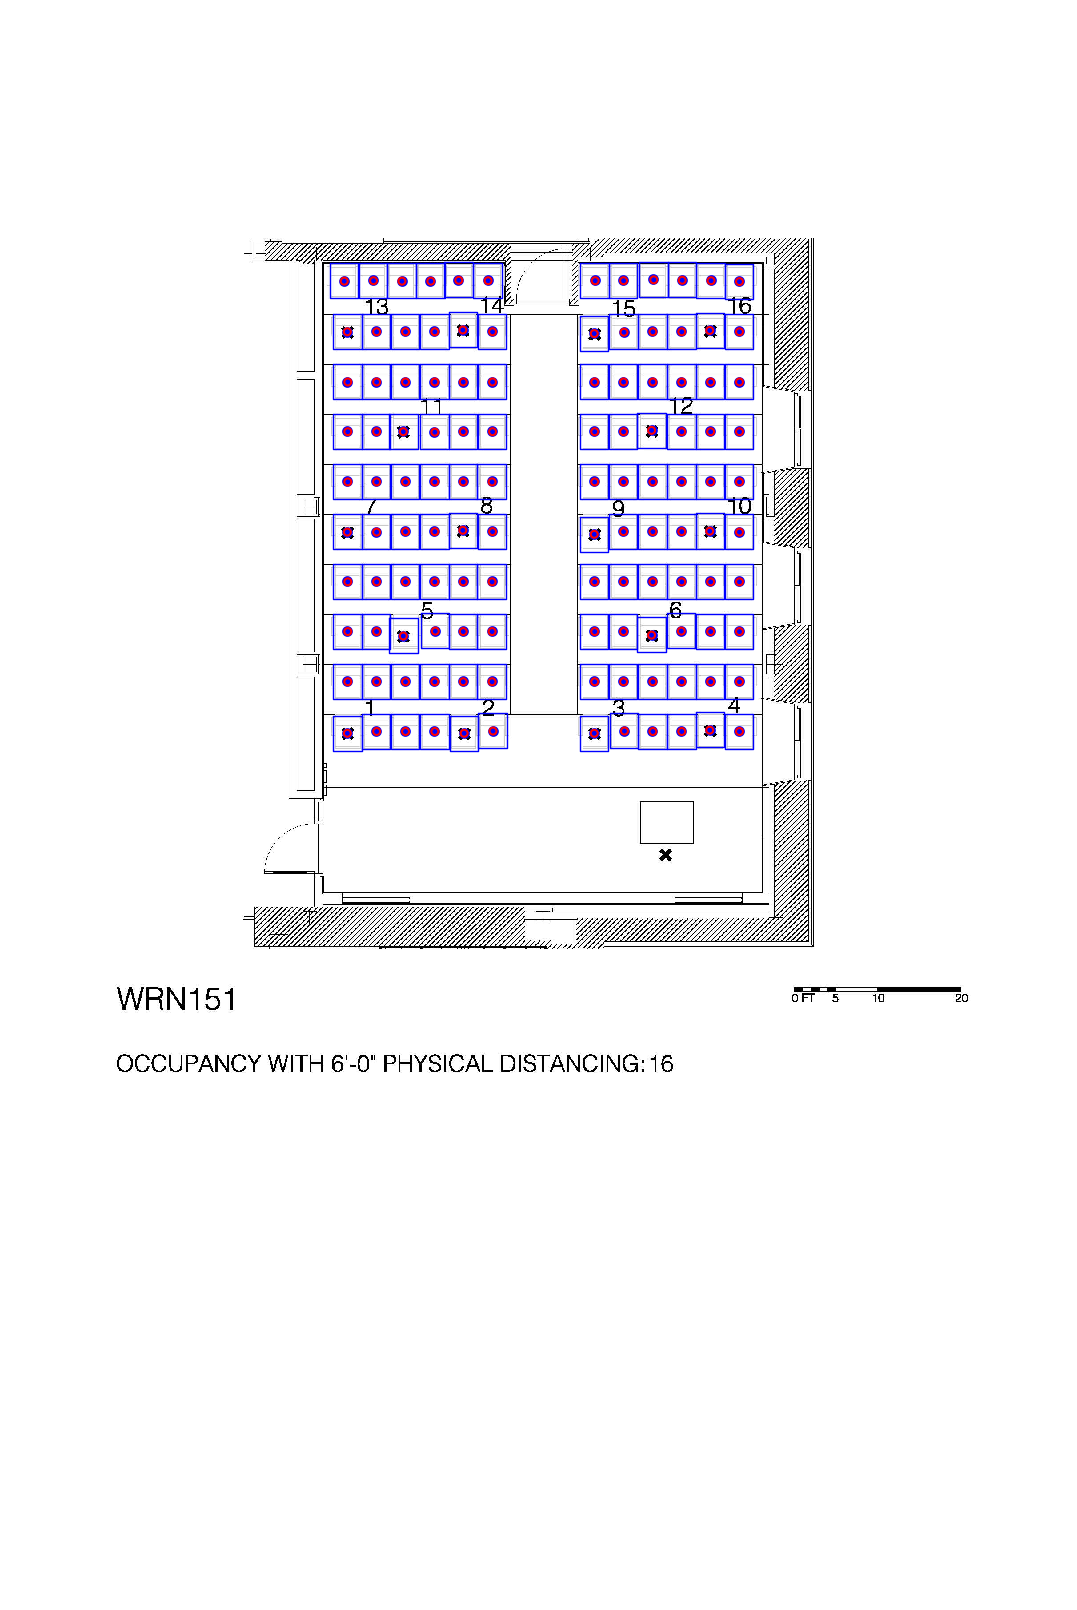

In [38]:
# plot all points to verify the matching worked
#df.reset_index(inplace=True)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=500)
plt.axis('off')

# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot polygons
for i in range(df.shape[0]):
    xz,yz = df['poly'][i].exterior.xy
    ax.plot(xz, yz, color='blue', alpha=1, linewidth=0.2, solid_capstyle='round', zorder=2)
    
# plot points    
xs = [df['middle'][i].x for i in df.index]
ys = [df['middle'][i].y for i in df.index]
plt.scatter(xs, ys, s=0.3, color='blue', alpha=1)
    
# plot points
plt.scatter(df['x'], df['y'], s=1, facecolors='none', edgecolors='red',
            alpha=1, marker='o', linewidth=0.3, linestyle='-', zorder=4)   

ax.imshow(NonWritableImage)

In [39]:
# generate edges from distances
edgelist = list()      # overall list of (directed) edges

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (i != j):
            dist = df['poly'][j].distance(df['middle'][i])
            if (dist <= feet6):
                edgelist.append((i,j)) # add edge if seat is too close
for i in range(df.shape[0]):
    if(df['poly'][i].intersects(zone)):
        edgelist.append((i,i))
print('There are %d edges.' % len(edgelist))

There are 1224 edges.


In [40]:
# solve problem
sol = miset(df.index.values, edgelist, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 20.0


In [41]:
# map solution to dataframe
df['index_string'] = df.index.astype(str) # get index as strings, dict is {'id': val}
df['in_solution'] = df['index_string'].map(sol)

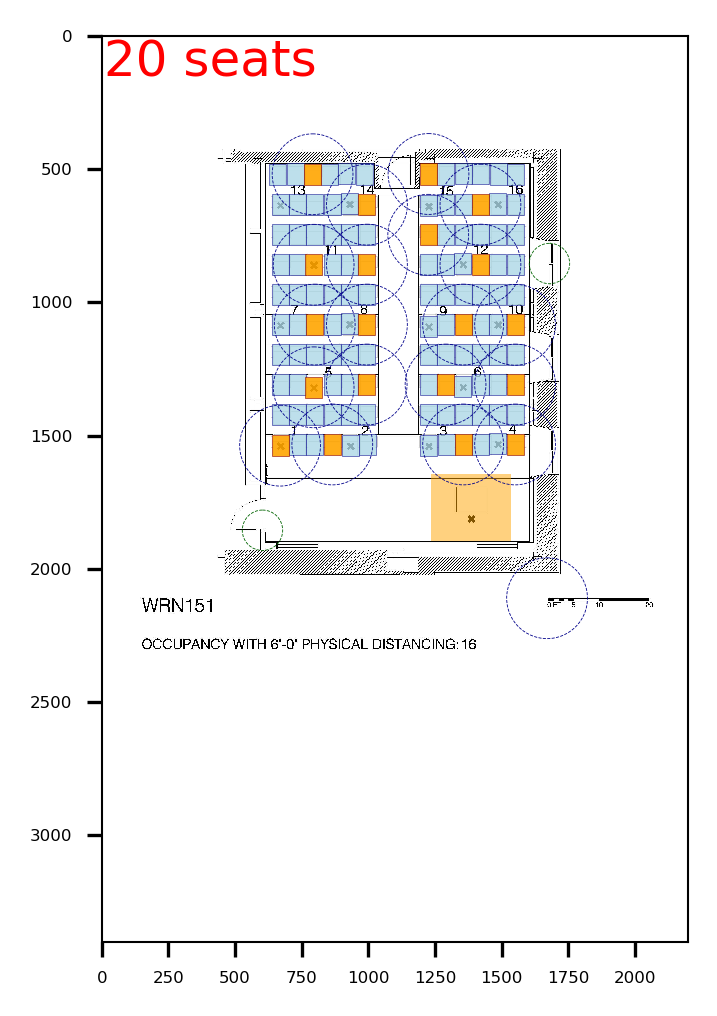

In [42]:
# plot all points to verify the matching worked
# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(df.shape[0]):
    if (df['in_solution'][i] == 0):
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.8, fc='lightblue', ec='darkblue', linewidth=0.15, zorder=2)
    else:
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)

# plot circles
sol_ids = df[df['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((df['middle'][i].x, df['middle'][i].y), feet6, fill=False,
                         ec='darkblue', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
for i in range(len(CheckPoints)):
    draw_circle = plt.Circle((CheckPoints[i]), feet6/2, fill=False,
                         ec='darkgreen', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
draw_circle=plt.Circle((x1avg,(y2avg+y1avg)/2), feet6, fill=False, ec='darkblue', ls='--', lw=0.2, zorder=4)
ax.add_artist(draw_circle)
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)
seats = 0
for i in sol.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')
ax.imshow(NonWritableImage)
plt.savefig(solution_name+".jpg",orientation='portrait',format='jpg',dpi=1000)

In [43]:
# generate edges from distances
edgelist97 = list()      # overall list of (directed) edges

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (i != j):
            dist = df['poly'][j].distance(df['middle'][i])
            if (dist <= feet6*0.97):
                edgelist97.append((i,j)) # add edge if seat is too close
for i in range(df.shape[0]):
    if(df['poly'][i].intersects(zone)):
        edgelist97.append((i,i))
print('There are %d edges.' % len(edgelist97))

There are 1224 edges.


In [44]:
# solve problem
sol97 = miset(df.index.values, edgelist97, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 20.0


In [45]:
# map solution to dataframe
df['index_string'] = df.index.astype(str) # get index as strings, dict is {'id': val}
df['in_solution'] = df['index_string'].map(sol97)

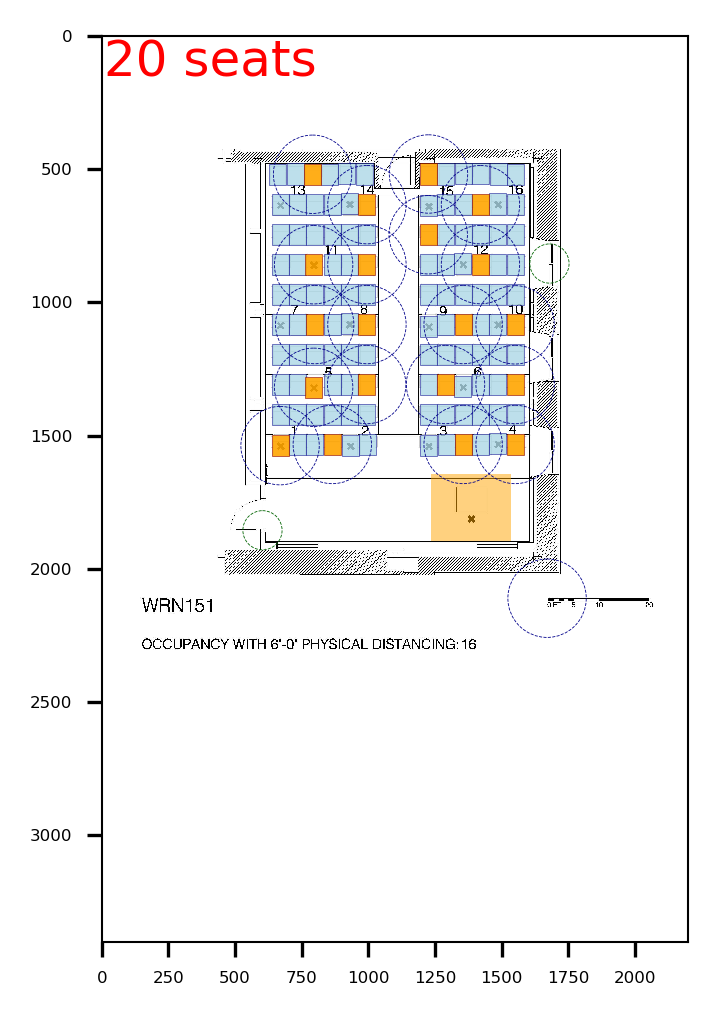

In [46]:
# plot all points to verify the matching worked
# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(df.shape[0]):
    if (df['in_solution'][i] == 0):
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.8, fc='lightblue', ec='darkblue', linewidth=0.15, zorder=2)
    else:
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)

# plot circles
sol_ids = df[df['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((df['middle'][i].x, df['middle'][i].y), feet6*0.97, fill=False,
                         ec='darkblue', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
for i in range(len(CheckPoints)):
    draw_circle = plt.Circle((CheckPoints[i]), feet6*0.97/2, fill=False,
                         ec='darkgreen', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
draw_circle=plt.Circle((x1avg,(y2avg+y1avg)/2), feet6*0.97, fill=False, ec='darkblue', ls='--', lw=0.2, zorder=4)
ax.add_artist(draw_circle)
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)
seats = 0
for i in sol97.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')
ax.imshow(NonWritableImage)
plt.savefig(solution_name+"-97"+".jpg",orientation='portrait',format='jpg',dpi=1000)

In [47]:
# generate edges from distances
edgelist103 = list()      # overall list of (directed) edges

for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (i != j):
            dist = df['poly'][j].distance(df['middle'][i])
            if (dist <= feet6*1.03):
                edgelist103.append((i,j)) # add edge if seat is too close
for i in range(df.shape[0]):
    if(df['poly'][i].intersects(zone)):
        edgelist103.append((i,i))
print('There are %d edges.' % len(edgelist103))

There are 1224 edges.


In [48]:
# solve problem
sol103 = miset(df.index.values, edgelist103, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 20.0


In [49]:
# map solution to dataframe
df['index_string'] = df.index.astype(str) # get index as strings, dict is {'id': val}
df['in_solution'] = df['index_string'].map(sol103)

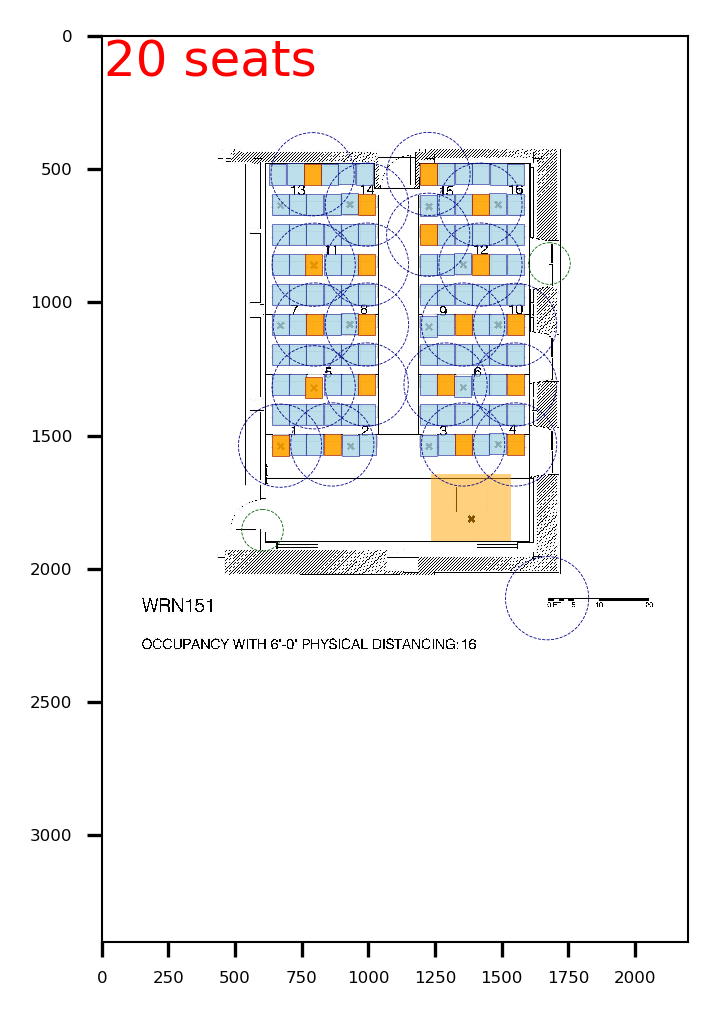

In [50]:
# plot all points to verify the matching worked
# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# plot chairs
for i in range(df.shape[0]):
    if (df['in_solution'][i] == 0):
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.8, fc='lightblue', ec='darkblue', linewidth=0.15, zorder=2)
    else:
        x,y = df['poly'][i].exterior.xy
        ax.fill(x, y, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)

# plot circles
sol_ids = df[df['in_solution']==1].index.values # get points in solution
for i in sol_ids:
    draw_circle = plt.Circle((df['middle'][i].x, df['middle'][i].y), feet6*1.03, fill=False,
                         ec='darkblue', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
for i in range(len(CheckPoints)):
    draw_circle = plt.Circle((CheckPoints[i]), feet6*1.03/2, fill=False,
                         ec='darkgreen', ls='--', lw=0.2, zorder=4)
    ax.add_artist(draw_circle)
draw_circle=plt.Circle((x1avg,(y2avg+y1avg)/2), feet6*1.03, fill=False, ec='darkblue', ls='--', lw=0.2, zorder=4)
ax.add_artist(draw_circle)
x,y = zone.exterior.xy
ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)
seats = 0
for i in sol103.values():
    seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')
ax.imshow(NonWritableImage)
plt.savefig(solution_name+"-103"+".jpg",orientation='portrait',format='jpg',dpi=1000)